<a href="https://colab.research.google.com/github/seobando/TradingBot/blob/main/implementations/APPL_2_YEARS_model_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Colab Set up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/1 Formal Training/2 Msc. Ciencia de los datos/Semestre IV/Trader

/content/drive/MyDrive/1 Formal Training/2 Msc. Ciencia de los datos/Semestre IV/Trader


## Libraries

In [ ]:
import torch
import random
import numpy as np
import pandas as pd
from env import environment
import time
from datetime import datetime
from mpl_toolkits import mplot3d
from collections import deque
from ddpg_agent import Agent
import matplotlib.pyplot as plt
env = environment()

In [ ]:
import time
from google.colab import output
import IPython
out = display(IPython.display.Pretty('Starting'), display_id=True)
time.sleep(1)

Starting

## Define Agent

In [ ]:
def ddpg_agent(experiment,InitialBudget,state_list,df,random_seed,fc1, fc2, fc3, fc4, fc5, fc6, fc7, fc8, fc9, fc10, fc11,learning_period, update_factor,layer_type,minibatch_size):       

    memory_structure = ["Date",
                        #"Open",
                        #"High",
                        #"Low",
                        "Close",
                        #"Volume",
                        "BuyPrice",
                        "InitialBudget",
                        "Budget",
                        "Action",
                        "Reward",
                        "Score",
                        "Buying",
                        "Selling"
                        ]

    memory_test = pd.DataFrame(columns=memory_structure)  

    monitoring_list = ["Date",
                      #"Open"
                      #"High",
                      #"Low",
                      "Close",
                      #"Volume"
                      ]

    possibilities = {0:"Hold",1:"Buy",2:"Sell"} 
    set_size = 3
    n_episodes = 25
    num_agents = 1
    action_size = 3
    state_size = len(state_list)
    print_every = 1
    deque_size = 10
    scores_deque = deque(maxlen=deque_size)
    duration_deque = deque(maxlen=deque_size)
    performance_deque = deque(maxlen=deque_size)
    global_score = []
    size = len(df.index)
    max_t = len(df.index)
    reward = 0
    average_score = 0
    average_performance = 0
    average_duration = 0  

    # Initialize agent
    agent = Agent(state_size, 
                action_size, 
                random_seed,
                fc1, fc2, fc3, fc4, fc5, fc6, fc7, fc8, fc9, fc10, fc11,
                learning_period, update_factor,
                layer_type,
                minibatch_size  
                )
    
    agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
    agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

    done = False
    Budget = InitialBudget
    BuyPrice = 0

    scores = np.zeros(num_agents)
    t = 0
    max_t = len(df.index)
    average_score = 0
    reward = 0

    start_time = time.time()

    print("max_t: ",max_t)

    while True:

        price = df["Close"].iloc[t]
        date = df["Date"].iloc[t]
        state = env.row_values(df,t,state_list,num_agents,state_size)
        actions = agent.act(state)
        reward,done,action,BuyPrice,Budget = env.step(done,reward,actions,price,BuyPrice,Budget,InitialBudget)      
        scores += reward

        # Game Pass
        if t+1 >= max_t:
            break    
        #--------
        # Monitoring    
        memory_list = []
        memory_list = df.iloc[t][monitoring_list].values.flatten().tolist()
        memory_list.append(BuyPrice)
        memory_list.append(InitialBudget)
        memory_list.append(Budget) 
        memory_list.append(possibilities.get(action))
        memory_list.append(reward)
        memory_list.append(np.mean(scores))

        # Save Buying actions
        if action == 1:
          memory_list.append(price)
        else:
          memory_list.append(np.nan) 
        
        # Save Selling actions
        if action == 2:
          memory_list.append(price)
        else:
          memory_list.append(np.nan) 

        memory_test = memory_test.append(pd.DataFrame([memory_list],columns=memory_structure))             
        #--------
        next_state = env.row_values(df,t+1,state_list,num_agents,state_size)    
        agent.step(state, actions, reward, next_state, done,t,minibatch_size)  
        t+=1

        # Game Lose
        if done:
            break                          

        # TEST
        performance = round(Budget/InitialBudget-1,2)    
        out.update(IPython.display.Pretty("Experiment: {experiment},date:  {date}, action: {action}, score: {score}, steps: {steps}, budget: {budget}, Performance: {performance}".format(experiment = experiment, date = date, action = possibilities[action] , score = round(np.mean(scores),2), steps = t, budget = round(Budget,2), performance = performance)))
        time.sleep(1)       

    end_time = time.time()        
    duration = end_time - start_time        
        
    performance = round(Budget/InitialBudget-1,2) 

    print('\rTotal score: {:.2f}\tProgres: {:.2f}\tTime: {:.2f}\tInitial Budget: {:.2f}\tFinal Budget: {:.2f}\tPerformance: {:.2f}'.format(np.mean(scores),t/size,duration,InitialBudget,Budget,performance))
    
    return memory_test

## Load Data

In [ ]:
experiments = pd.read_csv("data/experiment.csv").drop("Unnamed: 0",axis=1)
number_experiments = 1

dataset = "data/data_daily_interpreted_APPL.csv"
data = pd.read_csv(dataset)
df = data[data["Date"]>= "2020-01-01"]

## Implement Agent

In [ ]:
memory_structure = ["Date",
                    #"Open",
                    #"High",
                    #"Low",
                    "Close",
                    #"Volume",
                    "BuyPrice",
                    "InitialBudget",
                    "Budget",
                    "Action",
                    "Reward",
                    "Score",
                    "Buying",
                    "Selling"
                    ]

memory_test = pd.DataFrame(columns=memory_structure)  


kpis = ["Open_interpreted",
        "High_interpreted",
        "Low_interpreted",
        "MA_short_interpreted",
        "MA_long_interpreted",
        "EMA_short_interpreted",
        "EMA_long_interpreted",
        "MACD_interpreted",
        "BIAS_short_interpreted", 
        "BIAS_long_interpreted", 
        #"VR", 
        "OBV_interpreted"
        ]
    
results_structure = ["Experiment",
                     "Avg Performance",
                     "Avg Time",
                     "Avg Score"
                    ]

results = pd.DataFrame(columns=results_structure)        
# Loop
for i in range(number_experiments):

    ## Experiment
    experiment = experiments["Experiment"].iloc[i]
    ## KPIS
    state_list = kpis
    ## Nodes
    nodes = int(experiments["Nodes"].iloc[i]) 
    fc1 = nodes 
    fc2 = nodes
    fc3 = nodes
    fc4 = nodes
    fc5 = nodes
    fc6 = nodes
    fc7 = nodes 
    fc8 = nodes
    fc9 = nodes
    fc10 = nodes
    fc11 = nodes
    ## Layers Type
    layer_amount_type = experiments["Layer Amount Type"].iloc[i]
    ## Layer Type Critic
    layer_type = experiments["Layers Type"].iloc[i]
                
    if layer_type != "Constant":
        if nodes == int(600):
          fc6 = 600
          fc7 = 500
          fc8 = 400
          fc9 = 300
          fc10 = 300
          fc11 = 300
        else:
          fc6 = 1024
          fc7 = 512
          fc8 = 256
          fc9 = 128
          fc10 = 128
          fc11 = 128              
    ## Learning Period
    learning_period = experiments["Learning Period"].iloc[i]
    ## Update Factor 
    update_factor = experiments["Update Factor"].iloc[i]
    ## Random Seed
    random_seed = 42
    ## Minibatch Size
    minibatch_size = experiments["Minibatch"].iloc[i]         
    ## Initial Budget
    InitialBudget = df["High"].max()*10

    #TEST  
    test = [
            experiment,
            #state_list,
            nodes ,
            fc1 ,
            fc2,
            fc3,
            fc4,
            fc5,
            fc6,
            fc7,
            fc8,
            fc9,
            fc10,
            fc11,
            layer_amount_type,
            layer_type,
            learning_period,
            update_factor,
            random_seed,
            minibatch_size,    
            InitialBudget
          ]

    #print(test)      
    #print("Initial Budget: ", InitialBudget)

    memory_test = ddpg_agent(experiment,InitialBudget,state_list,df,random_seed,fc1, fc2, fc3, fc4, fc5, fc6, fc7, fc8, fc9, fc10, fc11,learning_period, update_factor,layer_amount_type,minibatch_size)

max_t:  506


Experiment: 26,date:  2021-12-31, action: Buy, score: -439.1, steps: 505, budget: 1706.52, Performance: -0.07

Total score: -440.10	Progres: 1.00	Time: 511.24	Initial Budget: 1828.80	Final Budget: 1706.52	Performance: -0.07


In [ ]:
memory_test = memory_test.reset_index().drop("index",axis=1)
memory_test.to_csv("data/memory_test.csv")

In [ ]:
results = pd.read_csv("data/memory_test.csv").drop("Unnamed: 0",axis=1)
results["Date"]= results["Date"].astype('datetime64[ns]')
results = results.set_index("Date")

## Visualization

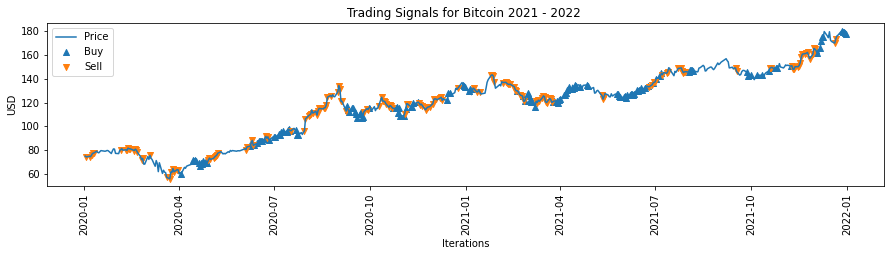

In [ ]:
x = results.index
y = results["Close"]
buy = results['Buying']
sell = results['Selling']

fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
plt.plot(x,y, label = "Price")
plt.scatter(x, buy, label='Buy', marker='^')
plt.scatter(x, sell, label='Sell', marker='v') 

plt.title("Trading Signals for Bitcoin 2021 - 2022 ")
plt.ylabel('USD')
plt.xlabel('Iterations')
plt.xticks(rotation=90)
plt.legend()
plt.show()